In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
# Carpeta - data diaria
ruta = "data/raw/osinergmin/"  
archivos = sorted(glob.glob(ruta + "osinergmin_*.csv"))

print(f"Archivos: {len(archivos)}")

dfs = []

for archivo in archivos:
    try:
        df = pd.read_csv(archivo)
        df["Origen"] = archivo  # para rastrear el archivo
        dfs.append(df)
    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")

# Concatenar todo
osinerg = pd.concat(dfs, ignore_index=True)

# Remover duplicados por si existen repeticiones
osinerg = osinerg.drop_duplicates()
osinerg.to_excel("data/consolidated/consolidado_osinergmin.xlsx", index=False)
osinerg.head(4)


Archivos: 22


,Distrito,Establecimiento,Dirección,Teléfono,Precio de Venta (Soles por galón),Departamento,Provincia,Producto,Fecha,Precio,Origen
0,ANCON,CENTER GAS SAC,"PANAMERICANA NORTE KM 44.5, SUB LOTE A-1 ASOCI...",016788937/948581946/981530091,13.35,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.35,data/raw/osinergmin\osinergmin_01_11_2025.csv
1,ANCON,SERVICIOS DE COMBUSTIBLES SANTA FE E.I.R.L.,"AA.HH. LAS PALMERAS MZ. C, LT. 14 (ANTES SERPE...",016983211/960690748/996437408,13.35,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.35,data/raw/osinergmin\osinergmin_01_11_2025.csv
2,ANCON,ESTACIÓN DE SERVICIOS ANCÓN S.A.,"PANAMERICANA NORTE KM. 44, URB. SAN JOSE, MZ. ...",945635871/993487080,13.6,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.60,data/raw/osinergmin\osinergmin_01_11_2025.csv
3,ANCON,EMPRESA DE TRANSPORTES Y SERVICIOS VIRGEN DE L...,AV. LA FLORIDA CDRA. 12 MIRAMAR . LAS CONCHITAS,967743212,13.79,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.79,data/raw/osinergmin\osinergmin_01_11_2025.csv


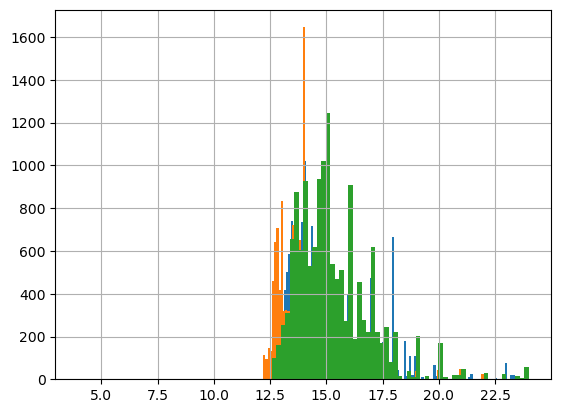

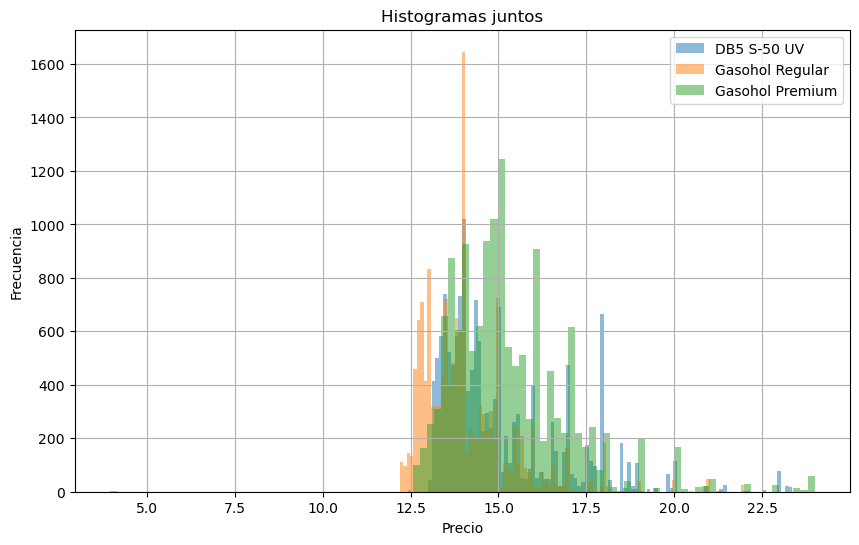

In [3]:
osinerg[osinerg["Producto"]=="DB5 S-50 UV"].Precio.hist(bins=100)
osinerg[osinerg["Producto"]=="Gasohol Regular"].Precio.hist(bins=100)
osinerg[osinerg["Producto"]=="Gasohol Premium"].Precio.hist(bins=100)

plt.figure(figsize=(10,6))

osinerg[osinerg["Producto"]=="DB5 S-50 UV"]["Precio"].hist(bins=100, alpha=0.5)
osinerg[osinerg["Producto"]=="Gasohol Regular"]["Precio"].hist(bins=100, alpha=0.5)
osinerg[osinerg["Producto"]=="Gasohol Premium"]["Precio"].hist(bins=100, alpha=0.5)

plt.title("Histogramas juntos")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.legend(["DB5 S-50 UV", "Gasohol Regular", "Gasohol Premium"])
plt.show()

In [4]:
df = osinerg

In [5]:
df["Fecha"] = pd.to_datetime(df["Fecha"])

# --- Agrupar por día con PROMEDIO GEOMÉTRICO + STD ---
daily = df.groupby("Fecha").agg(
    promedio_geom = ("Precio", lambda x: np.exp(np.log(x).mean())),
    volatilidad   = ("Precio", "std")
).reset_index()

# Renombrar para que todo use el promedio geométrico
daily["precio_base"] = daily["promedio_geom"]

# Bandas geom ± std
daily["banda_sup"] = daily["precio_base"] + daily["volatilidad"]
daily["banda_inf"] = daily["precio_base"] - daily["volatilidad"]

# Orden
daily = daily.sort_values("Fecha").reset_index(drop=True)

# --- Base 100 usando el 29-10-2025 ---
base_fecha = pd.to_datetime("2025-10-29")

base_valor = daily.loc[daily["Fecha"] == base_fecha, "precio_base"]

if base_valor.empty:
    raise ValueError("No existe información para la fecha base 29-10-2025.")

base_valor = base_valor.iloc[0]

# Índices base 100
daily["idx"]     = 100 * daily["precio_base"] / base_valor
daily["idx_sup"] = 100 * daily["banda_sup"]   / base_valor
daily["idx_inf"] = 100 * daily["banda_inf"]   / base_valor

daily.head()

,Fecha,promedio_geom,volatilidad,precio_base,banda_sup,banda_inf,idx,idx_sup,idx_inf
0,2025-10-29,14.769112,1.718184,14.769112,16.487296,13.050928,100.000000,111.633632,88.366368
1,2025-10-30,14.761622,1.719820,14.761622,16.481441,13.041802,99.949285,111.593991,88.304580
2,2025-10-31,14.735681,1.679853,14.735681,16.415533,13.055828,99.773640,111.147736,88.399544
3,2025-11-01,14.737500,1.680930,14.737500,16.418430,13.056570,99.785960,111.167350,88.404571
4,2025-11-02,14.736922,1.679748,14.736922,16.416670,13.057174,99.782047,111.155432,88.408662


In [6]:
daily["CATEGORIA"] = "COMBUSTIBLES"

daily_pivot = daily[["Fecha", "CATEGORIA", "idx"]].pivot_table(
    values="idx",  
    index=["CATEGORIA"],  
    columns=["Fecha"], 
    aggfunc='mean'  
)
daily_pivot.reset_index().to_excel("data/base100/base_combustibles.xlsx",index=False)

In [7]:
import plotly.graph_objects as go

fig = go.Figure()

# Línea principal
fig.add_trace(go.Scatter(
    x=daily["Fecha"],
    y=daily["idx"],
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

# # Banda superior
# fig.add_trace(go.Scatter(
#     x=daily["Fecha"],
#     y=daily["idx_sup"],
#     mode="lines",
#     name="Banda superior",
#     line=dict(width=1, dash="dot")
# ))

# # Banda inferior
# fig.add_trace(go.Scatter(
#     x=daily["Fecha"],
#     y=daily["idx_inf"],
#     mode="lines",
#     name="Banda inferior",
#     line=dict(width=1, dash="dot")
# ))

# # Relleno entre bandas
# fig.add_trace(go.Scatter(
#     x=pd.concat([daily["Fecha"], daily["Fecha"][::-1]]),
#     y=pd.concat([daily["idx_sup"], daily["idx_inf"][::-1]]),
#     fill="toself",
#     fillcolor="rgba(0, 100, 200, 0.15)",
#     line=dict(color="rgba(0,0,0,0)"),
#     hoverinfo="skip",
#     showlegend=False
# ))

fig.update_layout(
    title="Índice Diario (Base 100 = 29/10/2025) usando Promedio Geométrico",
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()


# ANALISIS EXPLORATORIO - OSINERGMIN

In [8]:
osinerg_1 = osinerg

In [9]:
# Función para eliminar outliers usando el método del Rango Intercuartílico (IQR)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)  # Percentil 25
    Q3 = df[col].quantile(0.75)  # Percentil 75
    IQR = Q3 - Q1  # Rango intercuartílico
    lower_bound = Q1 - 1.5 * IQR  # Límite inferior
    upper_bound = Q3 + 1.5 * IQR  # Límite superior
    
    # Filtrar los valores que están fuera de los límites
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Eliminar outliers en la columna 'Precio' y 'Fecha_num'
osinerg_1 = remove_outliers(osinerg_1, 'Precio')
osinerg_1 = remove_outliers(osinerg_1, 'Fecha_num')

# Verificar que los outliers han sido eliminados
print(f"Dataframe después de eliminar outliers: {osinerg_1.shape}")
print(osinerg_1.head())

# Ahora, eliminamos los NaN (en caso de que hayan quedado después de eliminar los outliers)
osinerg_1 = osinerg_1.dropna(subset=['Fecha_num', 'Precio'])

# Verificar que no hay NaN
print(osinerg_1[['Fecha_num', 'Precio']].isna().sum())

KeyError: 'Fecha_num'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Asegurándonos de que 'Fecha' esté en formato datetime
# osinerg_1['Fecha'] = pd.to_datetime(osinerg_1['Fecha'])

# **1. Histograma de Precios de Combustible**
plt.figure(figsize=(10, 6))
sns.histplot(osinerg_1['Precio'], kde=True, bins=30, color='blue')
plt.title('Distribución de Precios de Combustible', fontsize=16)
plt.xlabel('Precio en Soles por Galón', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# **2. Serie de Tiempo - Precios Promedio por Producto a lo largo del Tiempo**
plt.figure(figsize=(12, 6))
osinerg_1.groupby(['Fecha', 'Producto']).agg({'Precio': 'mean'}).unstack().plot()
plt.title('Precios Promedio de Combustibles por Producto a lo Largo del Tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio Promedio (Soles por Galón)', fontsize=12)
plt.legend(title='Producto', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# **3. Gráfico de Dispersión - Precio vs Distrito (para cada Producto)**
plt.figure(figsize=(10, 6))
sns.scatterplot(data=osinerg_1, x='Distrito', y='Precio', hue='Producto', palette='viridis', s=100, alpha=0.6)
plt.title('Dispersión de Precios por Distrito y Producto', fontsize=16)
plt.xlabel('Distrito', fontsize=12)
plt.ylabel('Precio (Soles por Galón)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# **4. Gráfico de Precios por Producto en cada Distrito (Boxplot)**
plt.figure(figsize=(15, 6))
sns.boxplot(data=osinerg_1, x='Distrito', y='Precio', hue='Producto', palette='Set2')
plt.title('Distribución de Precios por Producto y Distrito', fontsize=16)
plt.xlabel('Distrito', fontsize=12)
plt.ylabel('Precio (Soles por Galón)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


